# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
import json

%matplotlib inline

# Importing the warnings package to suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load .env enviroment variables
load_dotenv('env.txt')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Request the data from the API and explore it
btc_request = requests.get(btc_url)
btc_data = btc_request.json()
# print(json.dumps(btc_data, indent=4))

eth_request = requests.get(eth_url)
eth_data = eth_request.json()
# print(json.dumps(eth_data, indent=4))

In [6]:
# Fetch current BTC price
btc_price = btc_data['data']['1']['quotes']['USD']['price']
# print(btc_price)

# Fetch current ETH price
eth_price = eth_data['data']['1027']['quotes']['USD']['price']
# print(eth_price)

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $35580.00
The current value of your 5.3 ETH is $8529.82


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [9]:
# Format current date as ISO format
today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_portfolio

AGG                                      \
                            close    high     low trade_count    open   
timestamp                                                               
2020-07-14 04:00:00+00:00  118.67  118.74  118.58       14582  118.58   

                                                   SPY                 \
                            volume        vwap   close    high    low   
timestamp                                                               
2020-07-14 04:00:00+00:00  4295871  118.667416  318.93  319.76  312.0   

                                                                    
                          trade_count   open    volume        vwap  
timestamp                                                           
2020-07-14 04:00:00+00:00      580272  313.3  94625450  316.274678

In [10]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio.AGG.close.values[0])
spy_close_price = float(df_portfolio.SPY.close.values[0])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $118.67
Current SPY closing price: $318.93


In [11]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $15946.50
The current value of your 200 AGG shares is $23734.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

savings_data = [round(my_btc_value + my_eth_value,2), round(my_agg_value + my_spy_value,2)]

# Consolidate financial assets data
financial_assets = {
    # "amount": [round(my_btc_value + my_eth_value,2), round(my_agg_value + my_spy_value,2)]
    "amount": savings_data
}

# Create savings DataFrame
df_savings = pd.DataFrame(financial_assets).set_axis(["crypto","shares"])

# Display savings DataFrame
display(df_savings)

,amount
crypto,44109.82
shares,39680.50


<Axes: title={'center': 'Financial Assets'}, ylabel='amount'>

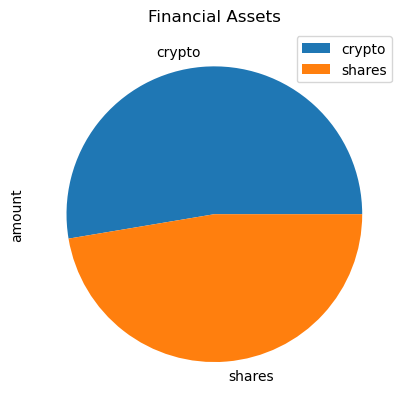

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Financial Assets")

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = my_btc_value + my_eth_value + my_agg_value + my_spy_value

# Validate saving health
print(f"Your emergency fund should be at least ${emergency_fund:.2f}.  You have ${total_savings:.2f} in total savings.")
if total_savings > emergency_fund:
    print(f"Congratulations! You have more than enough money in your emergency fund!")
elif total_savings == emergency_fund:
    print(f"Congratulations! You have reached your financial goal and you have exactly the right amount in your emergency fund!")
else:
    print(f"You are ${(emergency_fund - total_savings):.2f} away from your financial goal.")

Your emergency fund should be at least $36000.00.  You have $83790.32 in total savings.
Congratulations! You have more than enough money in your emergency fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [16]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                          \
                             close      high       low trade_count    open   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.605  110.7400  110.5200       15122  110.74   
2016-05-03 04:00:00+00:00  110.810  110.9450  110.7500       15663  110.89   
2016-05-04 04:00:00+00:00  110.860  110.9315  110.7595       13984  110.91   
2016-05-05 04:00:00+00:00  111.140  111.1600  110.8010       15708  110.92   
2016-05-06 04:00:00+00:00  110.970  111.1200  110.9700       12697  111.12   

                                                     SPY                  \
                            volume        vwap     close    high     low   
timestamp                                                                  
2016-05-02 04:00:00+00:00  3608552  110.626939  207.9700  208.18  206.41   
2016-05-03 04:00:00+00:00  3128774  110.864495  206.1592  206.80  205.28   
2016-05-04 04:00:00+00:00  3096337  110.877983  205.0100  205.85  204.42   
2016-05-05 04:00:00+00:00  3052967  111.030002  204.9700  205.98  204.47   
2016-05-06 04:00:00+00:00  2922700  111.027631  205.7200  205.77  203.88   

                                                                      
                          trade_count    open     volume        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00      263586  206.92   64747229  207.305695  
2016-05-03 04:00:00+00:00      377523  206.52  108050343  206.309997  
2016-05-04 04:00:00+00:00      345266  204.99   94995641  205.086315  
2016-05-05 04:00:00+00:00      280626  205.56   68425268  205.140615  
2016-05-06 04:00:00+00:00      340162  204.06   90999800  204.943796

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [18]:
# Printing the simulation input data
MC_thirty_years.portfolio_data.head()

AGG                                          \
                             close      high       low trade_count    open   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.605  110.7400  110.5200       15122  110.74   
2016-05-03 04:00:00+00:00  110.810  110.9450  110.7500       15663  110.89   
2016-05-04 04:00:00+00:00  110.860  110.9315  110.7595       13984  110.91   
2016-05-05 04:00:00+00:00  111.140  111.1600  110.8010       15708  110.92   
2016-05-06 04:00:00+00:00  110.970  111.1200  110.9700       12697  111.12   

                                                                  SPY          \
                            volume        vwap daily_return     close    high   
timestamp                                                                       
2016-05-02 04:00:00+00:00  3608552  110.626939          NaN  207.9700  208.18   
2016-05-03 04:00:00+00:00  3128774  110.864495     0.001853  206.1592  206.80   
2016-05-04 04:00:00+00:00  3096337  110.877983     0.000451  205.0100  205.85   
2016-05-05 04:00:00+00:00  3052967  111.030002     0.002526  204.9700  205.98   
2016-05-06 04:00:00+00:00  2922700  111.027631    -0.001530  205.7200  205.77   

                                                                              \
                              low trade_count    open     volume        vwap   
timestamp                                                                      
2016-05-02 04:00:00+00:00  206.41      263586  206.92   64747229  207.305695   
2016-05-03 04:00:00+00:00  205.28      377523  206.52  108050343  206.309997   
2016-05-04 04:00:00+00:00  204.42      345266  204.99   94995641  205.086315   
2016-05-05 04:00:00+00:00  204.47      280626  205.56   68425268  205.140615   
2016-05-06 04:00:00+00:00  203.88      340162  204.06   90999800  204.943796   

                                        
                          daily_return  
timestamp                               
2016-05-02 04:00:00+00:00          NaN  
2016-05-03 04:00:00+00:00    -0.008707  
2016-05-04 04:00:00+00:00    -0.005574  
2016-05-05 04:00:00+00:00    -0.000195  
2016-05-06 04:00:00+00:00     0.003659

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004181,0.994814,1.016945,0.999294,1.004002,1.006887,1.002346,1.003410,1.000591,0.994016,...,1.009535,0.997274,0.994132,0.998331,0.996537,1.007638,1.006267,1.002907,1.010674,0.994578
2,1.002498,1.004027,1.005277,0.987682,1.006571,1.010512,1.007231,1.012382,0.995098,1.008561,...,1.000258,1.000854,0.993571,0.995217,0.992669,1.004794,1.002065,1.011557,1.015345,0.987694
3,1.017261,1.018657,1.028923,0.986915,1.002599,1.016827,0.994001,1.015341,0.995613,1.002213,...,0.998192,1.001422,1.009391,0.990637,0.992392,1.015699,0.989682,1.008404,1.008898,0.988689
4,1.023564,1.018648,1.017897,0.986622,1.019510,1.011881,0.980170,1.013690,1.000313,1.001700,...,1.007220,1.009155,1.012611,0.981021,1.005005,1.017354,0.990130,1.008923,1.005209,0.989605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,18.528286,25.554344,7.289536,28.997419,13.146024,10.817796,20.671470,13.309382,15.144536,12.244911,...,13.700082,27.654178,6.782393,5.417819,18.380362,13.654705,44.843589,16.329855,12.087721,34.129269
7557,18.533666,25.486057,7.269171,28.634421,13.083330,10.891904,20.805070,13.335158,15.231482,12.405626,...,13.704124,27.344836,6.803692,5.474360,18.433505,13.705069,45.351086,16.363501,12.106904,34.080822
7558,18.725772,25.496605,7.266830,28.683566,13.141429,10.813908,20.779638,13.360515,15.333505,12.511964,...,13.679940,27.358221,6.785853,5.537134,18.321041,13.630575,45.729251,16.425408,12.087571,34.053450
7559,18.472735,25.138106,7.332290,28.559420,13.102206,10.659923,20.688344,13.414115,15.375865,12.537775,...,13.724978,27.590495,6.682965,5.566553,18.263839,13.558812,45.288479,16.370152,12.161015,34.246965


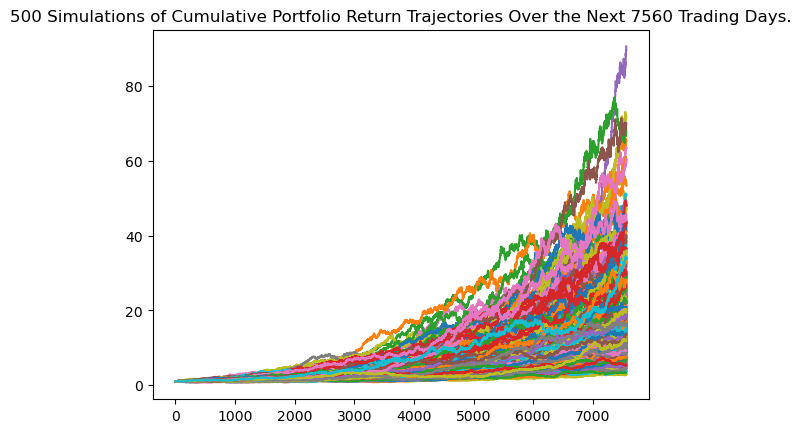

In [20]:
# Plot simulation outcomes
line_plot_thirty_years = MC_thirty_years.plot_simulation()

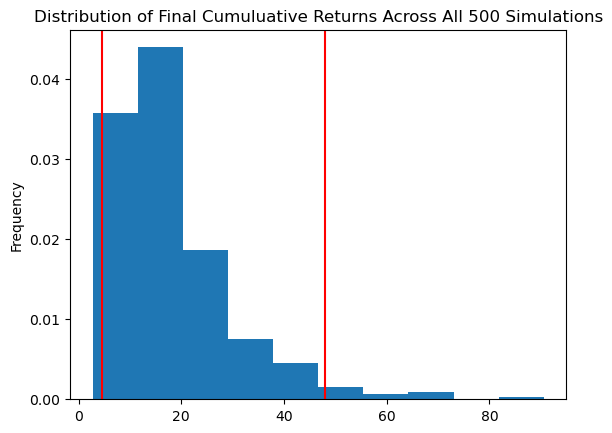

In [21]:
# Plot probability distribution and confidence intervals
distribution_plot_thirty_years = MC_thirty_years.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_table_thirty_years = MC_thirty_years.summarize_cumulative_return()

# Print summary statistics
print(summary_table_thirty_years)

count           500.000000
mean             18.141917
std              11.806479
min               2.767098
25%              10.217398
50%              14.924319
75%              22.469315
max              90.571218
95% CI Lower      4.569549
95% CI Upper     47.966172
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_table_thirty_years[8]*initial_investment,2)
ci_upper = round(summary_table_thirty_years[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:.2f} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower:.2f} and ${ci_upper:.2f}.\n\n"
      f"The predicted mean value of the portfolio after thirty years is ${round(summary_table_thirty_years[1]*initial_investment,2):.2f}.")

There is a 95% chance that an initial investment of $20000.00 in the portfolio over the next 30 years will end within in the range of $91390.97 and $959323.44.

The predicted mean value of the portfolio after thirty years is $362838.33.


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_table_thirty_years[8]*initial_investment,2)
ci_upper = round(summary_table_thirty_years[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:.2f} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower:.2f} and ${ci_upper:.2f}.\n\n"
      f"The predicted mean value of the portfolio after thirty years is ${round(summary_table_thirty_years[1]*initial_investment,2):.2f}.")

There is a 95% chance that an initial investment of $30000.00 in the portfolio over the next 30 years will end within in the range of $137086.46 and $1438985.17.

The predicted mean value of the portfolio after thirty years is $544257.50.


## Optional Challenge - Early Retirement


### Five Years Retirement Option - Higher Initial Investment

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years_higher_initial_investment = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years_higher_initial_investment.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000052,1.002688,0.996755,0.986579,0.998995,0.992475,0.997121,0.994707,0.995939,1.004663,...,1.005021,1.005540,0.990707,0.996896,0.997505,0.999937,1.003189,0.996946,1.005390,0.998954
2,0.999223,1.008693,1.005987,0.991880,0.993306,0.993159,1.007501,0.987112,0.999354,1.006338,...,1.006821,1.010411,0.990181,1.001235,1.002162,1.010075,1.003114,0.997277,0.998431,0.993377
3,1.002026,1.014284,1.004797,1.003059,0.976748,0.994166,1.017587,0.989039,1.005234,1.009659,...,1.009916,0.995607,0.997204,0.999533,0.994711,1.003328,1.002455,1.003943,1.009673,0.995526
4,1.013777,1.016224,1.010308,1.003410,0.970137,0.991942,1.015222,0.982040,1.002779,1.014274,...,1.020260,1.000852,0.999098,1.005105,0.995291,0.994570,1.001774,1.005182,1.012434,0.992240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.449916,1.402202,1.828967,2.220244,1.123201,1.617630,1.692380,1.557856,1.276528,0.763574,...,0.945963,1.654132,1.872273,1.534309,1.611972,1.511203,1.076140,1.586212,2.393195,1.127581
1257,1.449553,1.397011,1.835288,2.205891,1.119415,1.637068,1.684542,1.544468,1.266383,0.760487,...,0.943597,1.651271,1.892861,1.514368,1.580537,1.512725,1.083214,1.611089,2.430679,1.126330
1258,1.447745,1.413419,1.814870,2.238628,1.116417,1.638323,1.678863,1.533735,1.269509,0.761086,...,0.945866,1.644055,1.899423,1.512918,1.570505,1.519246,1.082960,1.638726,2.427372,1.111502
1259,1.451273,1.414753,1.799111,2.252213,1.111130,1.628257,1.680803,1.518074,1.255879,0.762990,...,0.952177,1.645488,1.883518,1.520687,1.570261,1.533320,1.088444,1.638143,2.416506,1.116439


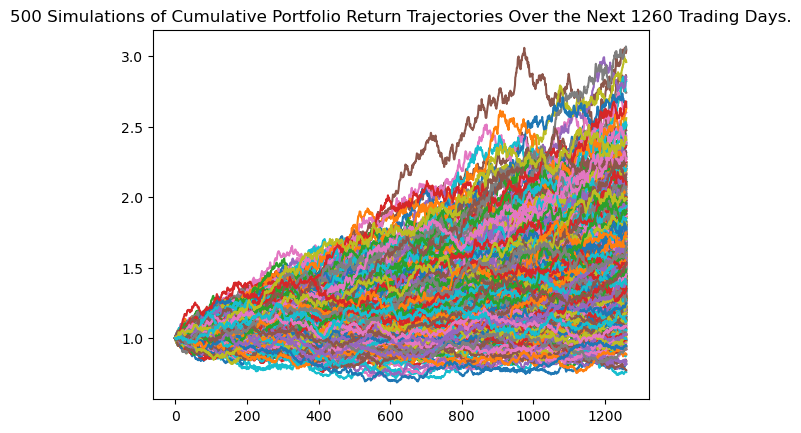

In [27]:
# Plot simulation outcomes
line_plot_five_years_higher_initial_investment = MC_five_years_higher_initial_investment.plot_simulation()

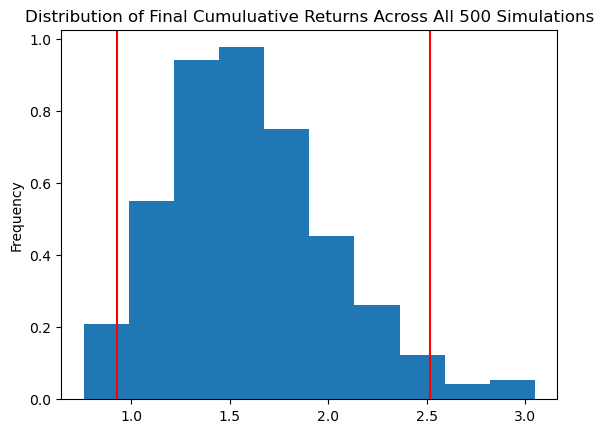

In [28]:
# Plot probability distribution and confidence intervals
distribution_plot_five_years_higher_initial_investment = MC_five_years_higher_initial_investment.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_table_five_years_higher_initial_investment = MC_five_years_higher_initial_investment.summarize_cumulative_return()

# Print summary statistics
print(summary_table_five_years_higher_initial_investment)

count           500.000000
mean              1.606391
std               0.411056
min               0.758939
25%               1.303558
50%               1.564129
75%               1.848281
max               3.050290
95% CI Lower      0.927870
95% CI Upper      2.518540
Name: 1260, dtype: float64


In [30]:
# Set initial investment
higher_initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five_higher_initial_investment = round(summary_table_five_years_higher_initial_investment[8]*higher_initial_investment,2)
ci_upper_five_higher_initial_investment = round(summary_table_five_years_higher_initial_investment[9]*higher_initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${higher_initial_investment:.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_higher_initial_investment:.2f} and ${ci_upper_five_higher_initial_investment:.2f}")

There is a 95% chance that an initial investment of $60000.00 in the portfolio over the next 5 years will end within in the range of $55672.18 and $151112.42


### Five Years Retirement Option - More Stocks in the Portfolio

In [31]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years_more_stocks = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.20,.80],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [32]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_years_more_stocks.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.981748,0.992980,0.986766,1.000262,1.004632,1.007229,0.996672,1.003139,0.980937,1.010450,...,0.982442,1.008044,1.015464,1.005939,0.987360,1.010067,1.009977,1.004412,0.987858,1.003313
2,0.967271,0.986356,0.983419,1.008507,1.013053,1.008744,1.010623,1.006233,0.968281,1.009270,...,0.987407,1.011384,1.019196,0.994315,0.980339,1.006229,1.006278,1.009974,0.995652,1.008356
3,0.990671,0.993263,0.977845,0.995189,1.016186,1.013770,1.009775,1.002842,0.965758,1.008763,...,0.987757,1.022843,1.026612,0.993250,0.979008,1.012592,1.013122,1.003521,0.995384,1.014781
4,0.977325,0.977647,0.987827,0.999119,1.015718,1.009903,1.018920,1.001657,0.945564,0.990304,...,0.996524,1.023788,1.036825,1.006538,0.977449,1.010765,1.013728,1.014490,1.017056,1.010327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.425437,0.909437,1.568656,1.745453,1.750175,1.845853,2.436458,2.137140,1.413535,1.983724,...,1.915224,2.729387,1.602836,2.303707,2.040042,2.433281,2.015889,1.547401,2.052821,2.214062
1257,1.438575,0.909550,1.579678,1.737861,1.751481,1.838413,2.461586,2.142784,1.420814,1.987287,...,1.890999,2.718458,1.598164,2.291683,2.018523,2.449277,2.004261,1.545006,2.067910,2.210124
1258,1.398736,0.914943,1.583480,1.723546,1.765253,1.847138,2.476903,2.174450,1.409308,1.990547,...,1.883588,2.732956,1.596453,2.274034,2.022804,2.468308,1.980937,1.564251,2.068402,2.209278
1259,1.401843,0.927470,1.614083,1.707775,1.763347,1.833179,2.498068,2.201184,1.406783,1.981061,...,1.882141,2.736896,1.597217,2.292961,1.980437,2.466556,1.974893,1.560690,2.094207,2.215783


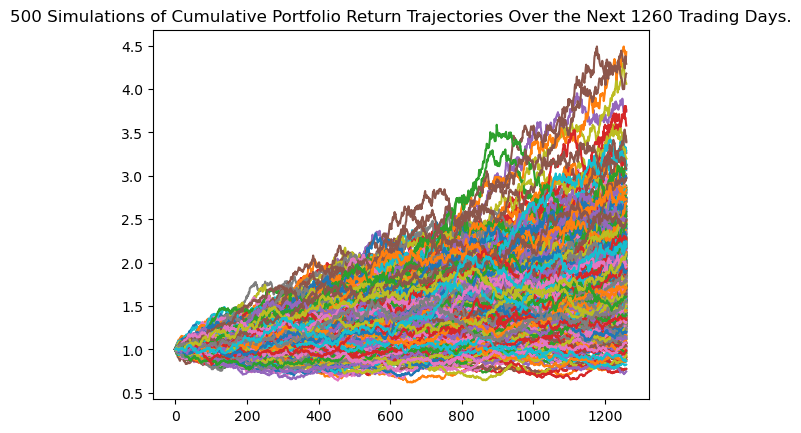

In [33]:
# Plot simulation outcomes
line_plot_five_years_more_stocks = MC_five_years_more_stocks.plot_simulation()

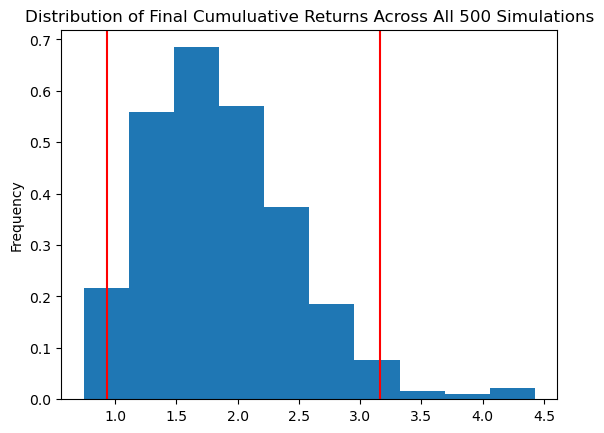

In [34]:
# Plot probability distribution and confidence intervals
distribution_plot_five_years_more_stocks = MC_five_years_more_stocks.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_table_five_years_more_stocks = MC_five_years_more_stocks.summarize_cumulative_return()

# Print summary statistics
print(summary_table_five_years_more_stocks)

count           500.000000
mean              1.859334
std               0.598848
min               0.745112
25%               1.415977
50%               1.786137
75%               2.217293
max               4.425217
95% CI Lower      0.932962
95% CI Upper      3.164887
Name: 1260, dtype: float64


In [36]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five_more_stocks = round(summary_table_five_years_more_stocks[8]*initial_investment,2)
ci_upper_five_more_stocks = round(summary_table_five_years_more_stocks[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five_more_stocks:.2f} and ${ci_upper_five_more_stocks:.2f}")

There is a 95% chance that an initial investment of $20000.00 in the portfolio over the next 5 years will end within in the range of $18659.24 and $63297.73


### Five Years Retirement Option Comparison:

In [37]:
print(f"Retiring in five years would require a much more aggressive portfolio than retiring in thirty years.")
print("")
print(f"For a portfolio that contains an initial investment of $60,000 and a 40/60 mixture of bonds/stocks respectively:")
print(f"     Mean value: ${round(summary_table_five_years_higher_initial_investment[1]*higher_initial_investment,2):.2f}")
print(f"     Lower confidence interval value: ${ci_lower_five_higher_initial_investment:.2f}")
print(f"     Upper confidence interval value: ${ci_upper_five_higher_initial_investment:.2f}")
print("")
print(f"For a portfolio that contains an initial investment of $20,000 and a 20/80 mixture of bonds/stocks respectively:")
print(f"     Mean value: ${round(summary_table_five_years_more_stocks[1]*initial_investment,2):.2f}")
print(f"     Lower confidence interval value: ${ci_lower_five_more_stocks:.2f}")
print(f"     Upper confidence interval value: ${ci_upper_five_more_stocks:.2f}")

Retiring in five years would require a much more aggressive portfolio than retiring in thirty years.

For a portfolio that contains an initial investment of $60,000 and a 40/60 mixture of bonds/stocks respectively:
     Mean value: $96383.48
     Lower confidence interval value: $55672.18
     Upper confidence interval value: $151112.42

For a portfolio that contains an initial investment of $20,000 and a 20/80 mixture of bonds/stocks respectively:
     Mean value: $37186.67
     Lower confidence interval value: $18659.24
     Upper confidence interval value: $63297.73


### Ten Years Retirement Option - Higher Initial Investment

In [38]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_years_higher_initial_investment = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [39]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_years_higher_initial_investment.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989568,1.000063,1.000435,1.006072,0.991984,0.998839,0.996184,1.012157,0.988117,0.993266,...,0.986329,0.997291,1.006090,1.000278,0.995481,0.991588,0.996442,0.999073,1.002019,1.003482
2,0.993510,0.999249,1.000287,1.020091,0.984737,0.996840,0.994367,1.015081,0.996846,1.000578,...,0.978566,0.980574,1.005073,0.997187,0.998687,0.976652,0.993605,1.007750,1.001742,0.991889
3,0.989119,0.992397,1.004806,1.035417,0.984689,0.995228,0.995603,1.011790,0.992286,1.010854,...,0.969372,0.981636,1.009733,1.002107,1.009611,0.982429,0.997179,1.006443,1.002369,0.993469
4,0.995280,0.993760,0.985682,1.030632,0.972281,0.993131,0.996172,1.005983,0.997984,1.006684,...,0.971518,0.983418,1.015161,1.015393,1.019195,0.983282,0.990109,1.014307,1.007601,0.984340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.726574,3.200180,4.190941,2.148925,2.122310,3.581083,2.426769,1.822649,2.645531,2.007541,...,3.392137,2.904575,1.964453,2.868292,2.540694,2.567309,2.183172,2.846412,2.578129,2.710473
2517,1.713322,3.188716,4.213974,2.165538,2.112714,3.610788,2.423385,1.830047,2.628183,1.998979,...,3.397462,2.909864,1.950083,2.866354,2.543417,2.574725,2.194400,2.860961,2.605165,2.686682
2518,1.702855,3.232135,4.237084,2.175143,2.105735,3.615599,2.404179,1.835982,2.619565,2.017746,...,3.395729,2.925582,1.948977,2.867065,2.558044,2.606911,2.178153,2.893247,2.608978,2.698091
2519,1.700809,3.182084,4.266422,2.185596,2.068355,3.606937,2.431237,1.839933,2.628558,2.015427,...,3.382363,2.933251,1.990844,2.849955,2.549995,2.630794,2.202659,2.894832,2.591613,2.675790


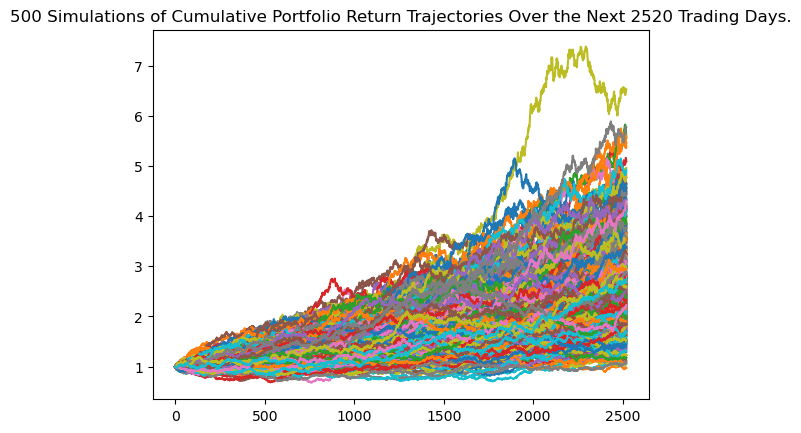

In [40]:
# Plot simulation outcomes
line_plot_ten_years_higher_initial_investment = MC_ten_years_higher_initial_investment.plot_simulation()

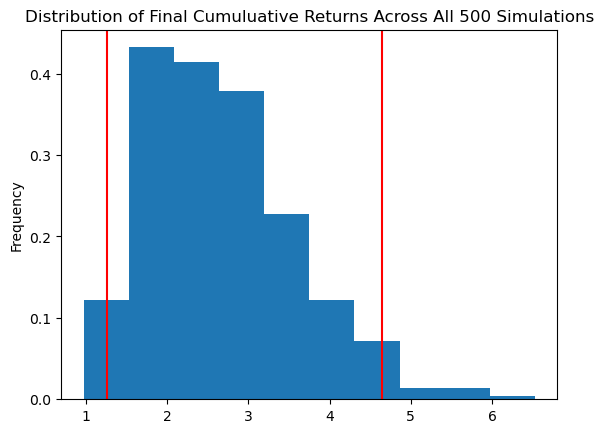

In [41]:
# Plot probability distribution and confidence intervals
distribution_plot_ten_years_higher_initial_investment = MC_ten_years_higher_initial_investment.plot_distribution()

In [42]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_table_ten_years_higher_initial_investment = MC_ten_years_higher_initial_investment.summarize_cumulative_return()

# Print summary statistics
print(summary_table_ten_years_higher_initial_investment)

count           500.000000
mean              2.668746
std               0.900892
min               0.976016
25%               1.994361
50%               2.559056
75%               3.199130
max               6.526341
95% CI Lower      1.258771
95% CI Upper      4.644879
Name: 2520, dtype: float64


In [43]:
# Set initial investment
higher_initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten_higher_initial_investment = round(summary_table_ten_years_higher_initial_investment[8]*higher_initial_investment,2)
ci_upper_ten_higher_initial_investment = round(summary_table_ten_years_higher_initial_investment[9]*higher_initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${higher_initial_investment:.2f} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten_higher_initial_investment:.2f} and ${ci_upper_ten_higher_initial_investment:.2f}")

There is a 95% chance that an initial investment of $60000.00 in the portfolio over the next 10 years will end within in the range of $75526.25 and $278692.73


### Ten Years Retirement Option - More Stocks in the Portfolio

In [44]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_ten_years_more_stocks = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.20,.80],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [45]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_ten_years_more_stocks.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989615,0.988047,1.001905,0.999047,0.996081,0.997607,0.994562,0.998927,0.990921,1.006260,...,0.992804,0.987503,0.996815,1.007063,0.996556,0.997694,1.007420,0.996680,1.021880,1.000881
2,0.992707,1.011014,1.008425,1.009250,0.992195,0.996550,0.998697,1.003634,0.996513,0.999534,...,0.989844,0.983661,1.000612,1.002826,0.993478,0.996981,0.993403,1.010786,1.009082,0.997435
3,0.994190,1.002866,1.010307,1.017357,1.006214,1.023697,0.996270,1.008842,0.996404,1.004370,...,0.995017,0.975885,0.998913,1.002695,0.987332,0.986134,0.969706,1.003316,1.013566,1.004407
4,0.990555,0.997174,0.996637,0.997860,1.021126,1.008003,1.005791,1.001270,1.009422,1.014083,...,0.977482,0.986762,0.996749,1.006300,0.998179,0.990806,0.980065,1.008914,1.020079,0.983866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.880688,4.083129,2.080233,3.247199,3.406019,2.297698,3.153513,2.175075,4.175132,4.521104,...,4.234161,1.688456,1.912612,5.210408,2.900062,5.842056,4.233101,2.896475,5.593284,1.578088
2517,2.884115,4.073823,2.086266,3.251746,3.401321,2.246005,3.197263,2.156038,4.206424,4.443783,...,4.194312,1.683773,1.904407,5.164732,2.879601,5.887357,4.235278,2.884101,5.571893,1.579576
2518,2.844884,4.129960,2.083595,3.225448,3.386514,2.252941,3.235415,2.143136,4.201564,4.422031,...,4.214599,1.664549,1.910329,5.183599,2.912255,5.871415,4.239857,2.892143,5.493223,1.614629
2519,2.874665,4.123558,2.077870,3.267268,3.384659,2.250793,3.262778,2.126689,4.192945,4.450993,...,4.221711,1.696010,1.905712,5.203524,2.909896,5.845860,4.192232,2.875347,5.441993,1.607368


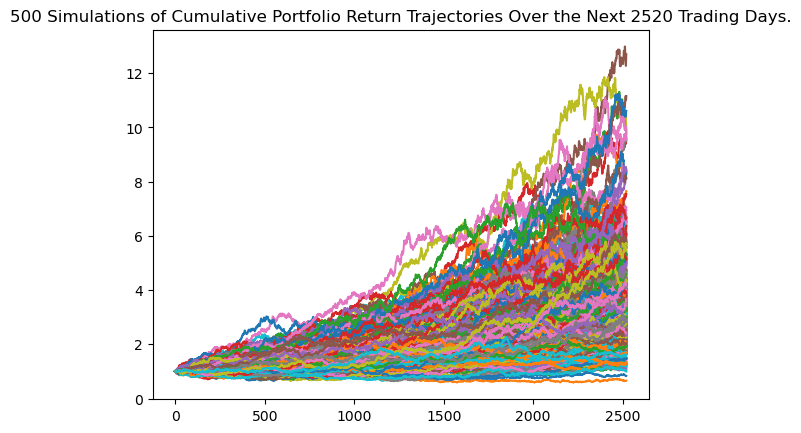

In [46]:
# Plot simulation outcomes
line_plot_ten_years_more_stocks = MC_ten_years_more_stocks.plot_simulation()

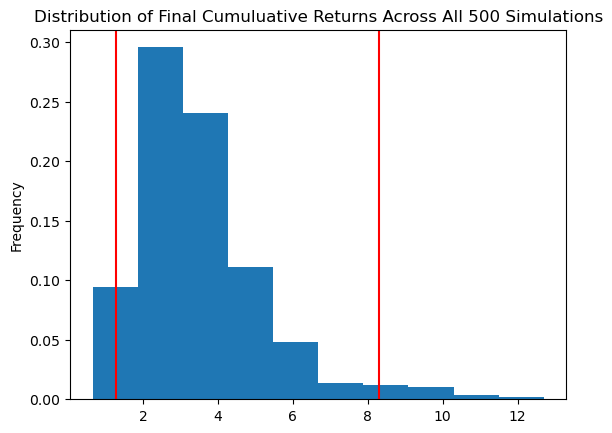

In [47]:
# Plot probability distribution and confidence intervals
distribution_plot_ten_years_more_stocks = MC_ten_years_more_stocks.plot_distribution()

In [48]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_table_ten_years_more_stocks = MC_ten_years_more_stocks.summarize_cumulative_return()

# Print summary statistics
print(summary_table_ten_years_more_stocks)

count           500.000000
mean              3.509323
std               1.720217
min               0.660749
25%               2.314501
50%               3.168639
75%               4.224891
max              12.698191
95% CI Lower      1.269862
95% CI Upper      8.300815
Name: 2520, dtype: float64


In [49]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten_more_stocks = round(summary_table_ten_years_more_stocks[8]*initial_investment,2)
ci_upper_ten_more_stocks = round(summary_table_ten_years_more_stocks[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_ten_more_stocks:.2f} and ${ci_upper_ten_more_stocks:.2f}")

There is a 95% chance that an initial investment of $20000.00 in the portfolio over the next 5 years will end within in the range of $25397.24 and $166016.29


### Ten Years Retirement Option Comparison:

In [50]:
print(f"Retiring in ten years would require a much more aggressive portfolio than retiring in thirty years.")
print("")
print(f"For a portfolio that contains an initial investment of $60,000 and a 40/60 mixture of bonds/stocks respectively:")
print(f"     Mean value: ${round(summary_table_ten_years_higher_initial_investment[1]*higher_initial_investment,2):.2f}")
print(f"     Lower confidence interval value: ${ci_lower_ten_higher_initial_investment:.2f}")
print(f"     Upper confidence interval value: ${ci_upper_ten_higher_initial_investment:.2f}")
print("")
print(f"For a portfolio that contains an initial investment of $20,000 and a 20/80 mixture of bonds/stocks respectively:")
print(f"     Mean value: ${round(summary_table_ten_years_more_stocks[1]*initial_investment,2):.2f}")
print(f"     Lower confidence interval value: ${ci_lower_ten_more_stocks:.2f}")
print(f"     Upper confidence interval value: ${ci_upper_ten_more_stocks:.2f}")

Retiring in ten years would require a much more aggressive portfolio than retiring in thirty years.

For a portfolio that contains an initial investment of $60,000 and a 40/60 mixture of bonds/stocks respectively:
     Mean value: $160124.74
     Lower confidence interval value: $75526.25
     Upper confidence interval value: $278692.73

For a portfolio that contains an initial investment of $20,000 and a 20/80 mixture of bonds/stocks respectively:
     Mean value: $70186.45
     Lower confidence interval value: $25397.24
     Upper confidence interval value: $166016.29


### Summary: Higher Initial Investment vs. More Stocks in the Portfolio

For both the 5- and 10-year cases, having an initial investment of \\$60,000 as opposed to \\$20,000 resulted in a higher mean value of the portfolio than shifting the balance of bonds/stocks from 40/60 to 20/80.  Even though moving to more stocks increases the mean return on a percentage basis, the change in the initial investment is so large (200% increase) that it's hard for the stock-heavy portfolio to outperform the higher initial investment portfolio in the time period allotted.

### Summary: 30 years vs. 5 and 10 years

The return on 30 years of investment is significantly higher than the return on 5 or 10 years of investment.  Even the best case for a 10-year plan (\\$60,000 initial investment) still results in a significantly lower mean value than a 30-year plan with a lower initial investment.  Whether or not a person could retire after only 10 years of investment may depend on their financial goals, but it would be significantly harder to retire with a much shorter plan.